# 🥋 Lekcja 19: Augmentacja na GPU (Kornia vs Torchvision)

Standardowy `torchvision.transforms` działa głównie na obrazkach PIL (CPU).
Gdy trenujesz szybką sieć (np. ResNet18) na szybkim GPU, procesor może stać się wąskim gardłem (**CPU Bottleneck**).

**Rozwiązanie:**
Przenieś augmentację na kartę graficzną.
Zamiast przetwarzać każde zdjęcie osobno w `__getitem__`, wrzucasz surowy batch na GPU i przetwarzasz **128 zdjęć naraz** za pomocą operacji tensorowych.

Użyjemy biblioteki **Kornia**, która implementuje transformacje (obrót, crop, kolor) jako warstwy `nn.Module`.

In [3]:
# Instalacja Kornii (OpenCV dla PyTorcha)
!uv pip install kornia
!uv pip install matplotlib

import torch
import torch.nn as nn
from torchvision import transforms
import kornia.augmentation as K
import time
import matplotlib.pyplot as plt

# Sprawdźmy sprzęt
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Będziemy przyspieszać na: {device}")

# Symulacja Batcha Zdjęć (np. 64 obrazki 256x256 RGB)
BATCH_SIZE = 64
IMG_SIZE = 256
fake_batch_cpu = torch.rand(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE)
fake_batch_gpu = fake_batch_cpu.to(device)

print(f"Batch: {fake_batch_cpu.shape}")

Audited 1 package in 3ms
Resolved 11 packages in 721ms
Prepared 1 package in 236ms
Installed 6 packages in 232ms
 + contourpy==1.3.3
 + cycler==0.12.1
 + fonttools==4.61.1
 + kiwisolver==1.4.9
 + matplotlib==3.10.8
 + pyparsing==3.3.1


Będziemy przyspieszać na: cuda
Batch: torch.Size([64, 3, 256, 256])


## Podejście 1: CPU (Torchvision)

Tradycyjny pipeline.
Symulujemy to pętlą, bo `DataLoader` normalnie wywołuje te transformacje sekwencyjnie dla każdego obrazka (chyba że mamy wielu workerów, ale i tak narzut procesów jest duży).

In [4]:
# Definicja potoku CPU
cpu_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

print("Start augmentacji na CPU...")
start = time.time()

# Symulacja przetwarzania w DataLoaderze (obrazek po obrazku)
processed_cpu = []
for img in fake_batch_cpu:
    processed_cpu.append(cpu_transform(img))

# Stackujemy z powrotem w batch
batch_cpu = torch.stack(processed_cpu).to(device) # Na koniec wysyłamy na GPU

end = time.time()
cpu_time = end - start
print(f"Czas CPU (sekwencyjnie + transfer): {cpu_time:.4f} s")

Start augmentacji na CPU...
Czas CPU (sekwencyjnie + transfer): 0.1884 s


## Podejście 2: GPU (Kornia)

Definiujemy augmentację jako **Model (`nn.Sequential`)**.
Wrzucamy cały tensor `(B, C, H, W)` na GPU.
Kornia robi swoje operacje używając rdzeni CUDA, równolegle dla wszystkich pikseli we wszystkich obrazkach.

*Uwaga: Nowy `torchvision.transforms.v2` też to potrafi, ale Kornia jest często szybsza i bardziej elastyczna.*

In [5]:
# Definicja potoku GPU (Kornia)
# Zauważ: To jest nn.Sequential! Możesz to włożyć do środka swojego modelu!
gpu_transform = nn.Sequential(
    K.RandomRotation(degrees=45.0),
    K.ColorJitter(brightness=0.5),
    K.RandomHorizontalFlip(p=0.5)
).to(device)

print("Start augmentacji na GPU...")

# 1. Najpierw transfer całego batcha (zwykle dzieje się w tle przy pin_memory)
start_transfer = time.time()
batch_on_gpu = fake_batch_cpu.to(device)

# 2. Augmentacja (równolegle na tensorach)
# Kornia nie potrzebuje pętli!
batch_gpu = gpu_transform(batch_on_gpu)

# Synchronizacja CUDA (żeby zmierzyć prawdziwy czas, bo GPU działa asynchronicznie)
if device == "cuda":
    torch.cuda.synchronize()

end = time.time()
gpu_time = end - start_transfer

print(f"Czas GPU (transfer + massive parallel compute): {gpu_time:.4f} s")

Start augmentacji na GPU...
Czas GPU (transfer + massive parallel compute): 0.6049 s


------------------------------
Przyspieszenie: 0.31x
🐌 CPU wygrywa? (Możliwe przy bardzo małych obrazkach lub braku CUDA).


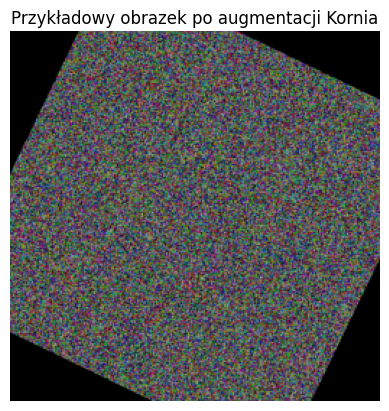

In [6]:
# Porównanie
speedup = cpu_time / gpu_time
print("-" * 30)
print(f"Przyspieszenie: {speedup:.2f}x")

if speedup > 1.0:
    print("🚀 GPU wygrywa! CPU może odpocząć.")
else:
    print("🐌 CPU wygrywa? (Możliwe przy bardzo małych obrazkach lub braku CUDA).")

# Wizualizacja (Czy to w ogóle działa?)
# Bierzemy pierwszy obrazek z batcha GPU
img_viz = batch_gpu[0].cpu().permute(1, 2, 0).numpy()

plt.imshow(img_viz)
plt.title("Przykładowy obrazek po augmentacji Kornia")
plt.axis("off")
plt.show()

## 🥋 Black Belt Summary

**Kiedy używać augmentacji na GPU?**
1.  **Duże modele wizyjne:** Gdy CPU nie nadąża karmić GPU.
2.  **Skomplikowane augmentacje:** Rotacje, rzuty perspektywiczne, rozmycia (to ciężka matematyka macierzowa, GPU to kocha).
3.  **Differentiable Augmentation:** Gdy chcesz, aby augmentacja była częścią procesu uczenia (np. w GAN-ach, żeby różniczkować przez augmentację).

**Wzorzec projektowy:**
Zamiast robić transformacje w `Dataset`, zwracaj surowe tensory.
Wsadź blok `Kornia` lub `torchvision.transforms.v2` jako **pierwszą warstwę swojego modelu** w `nn.Module`.
Wtedy augmentacja staje się częścią grafu obliczeniowego na GPU.